In [57]:
import re
import random
import pandas as pd
import hashlib

In [58]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [59]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Powershell,466.729626,93.345925,243.060387,5
Todd Ideas,844.829491,56.321966,147.027708,15
PEP 8,1347.591492,168.448937,575.353165,8
SharePoint,1577.839484,131.486624,568.935759,12
Audit Report Tracker (Sharepoint List),1675.036038,128.848926,354.454134,13
Debugging in VS Code,1801.773112,90.088656,242.068342,20
Terraform,1856.471768,74.258871,247.598829,25
Azure Functions + Visual Studio,1864.193842,133.156703,476.388933,14
IW Migration,2019.305499,144.236107,452.760988,14
Open Source/GitHub,2170.654947,135.665934,353.024949,16


# Histogram

82814.50


<Axes: >

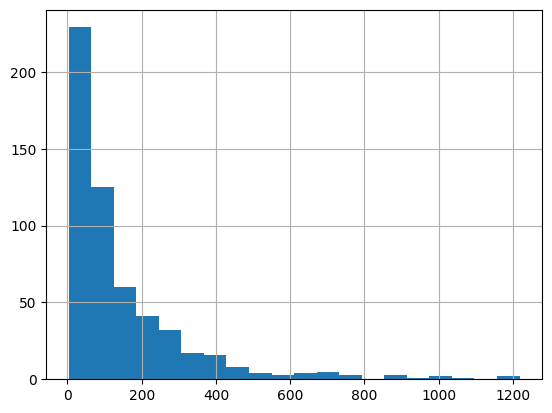

In [60]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [61]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [62]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [63]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [64]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [65]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [66]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [67]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [68]:
# n=10
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [69]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 556


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
12,OData,IsSideEffecting Annotation (Org.OData.Core.V1....,d8914b66a46000e7d49d28751ef0ce4d,-993.173812,-346.882825,993.173812,5203.242381,0.461100,0,0
84,OData,"Metadata in OData describes the structure, dat...",6481d267891f44f7021eb148e72d7a2d,-469.610519,-346.882825,993.173812,5203.242381,0.461100,3,0
155,OData,Annotations provide additional metadata about ...,e10bfb62a2d41b4902e31c6dfa97b22a,-357.581225,-346.882825,993.173812,5203.242381,0.461100,6,0
223,OData,OData-defined system query options are optiona...,92d41ab5b340318de6b606ed3f94fda4,-175.922694,-346.882825,993.173812,5203.242381,0.461100,9,0
288,OData,OData services SHOULD NOT require any query op...,7b3849723952f8c81c62d569b4505b3e,-131.386707,-346.882825,993.173812,5203.242381,0.461100,12,0
3,Home Network Project,Front: What is TLS Termination and why is it u...,5297051eea9892af904815d3794faf15,-1194.653442,-283.160248,1194.653442,5380.044713,0.642578,0,0
75,Home Network Project,Front: What is Bandwidth and how does it diffe...,8d6d825a0008723089184f0a0131e2d6,-455.200840,-283.160248,1194.653442,5380.044713,0.642578,3,0
146,Home Network Project,Front: What is Rate Limiting and how does it h...,8178df4fba6be87bebbac33e10e32135,-304.248855,-283.160248,1194.653442,5380.044713,0.642578,6,0
214,Home Network Project,Front: What is Fail2Ban and how does it protec...,d7fc83e3380f6d95ec44141a17d86066,-190.635429,-283.160248,1194.653442,5380.044713,0.642578,9,0
279,Home Network Project,How do you install Docker on a Raspberry Pi?\n...,7900b83a7ba7844a4c599eafecb06af7,-90.045415,-283.160248,1194.653442,5380.044713,0.642578,12,0


## Age Max

In [70]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [71]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [72]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [73]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
12,OData,IsSideEffecting Annotation (Org.OData.Core.V1....,d8914b66a46000e7d49d28751ef0ce4d,-993.173812,-346.882825,993.173812,5203.242381,0.461100,0,0
84,OData,"Metadata in OData describes the structure, dat...",6481d267891f44f7021eb148e72d7a2d,-469.610519,-346.882825,993.173812,5203.242381,0.461100,3,0
155,OData,Annotations provide additional metadata about ...,e10bfb62a2d41b4902e31c6dfa97b22a,-357.581225,-346.882825,993.173812,5203.242381,0.461100,6,0
223,OData,OData-defined system query options are optiona...,92d41ab5b340318de6b606ed3f94fda4,-175.922694,-346.882825,993.173812,5203.242381,0.461100,9,0
288,OData,OData services SHOULD NOT require any query op...,7b3849723952f8c81c62d569b4505b3e,-131.386707,-346.882825,993.173812,5203.242381,0.461100,12,0
3,Home Network Project,Front: What is TLS Termination and why is it u...,5297051eea9892af904815d3794faf15,-1194.653442,-283.160248,1194.653442,5380.044713,0.642578,0,0
75,Home Network Project,Front: What is Bandwidth and how does it diffe...,8d6d825a0008723089184f0a0131e2d6,-455.200840,-283.160248,1194.653442,5380.044713,0.642578,3,0
146,Home Network Project,Front: What is Rate Limiting and how does it h...,8178df4fba6be87bebbac33e10e32135,-304.248855,-283.160248,1194.653442,5380.044713,0.642578,6,0
214,Home Network Project,Front: What is Fail2Ban and how does it protec...,d7fc83e3380f6d95ec44141a17d86066,-190.635429,-283.160248,1194.653442,5380.044713,0.642578,9,0
279,Home Network Project,How do you install Docker on a Raspberry Pi?\n...,7900b83a7ba7844a4c599eafecb06af7,-90.045415,-283.160248,1194.653442,5380.044713,0.642578,12,0


In [74]:
existing_cards['age'].mean()

-148.94694416742612